In [4]:
import sklearn.svm as sk
import sklearn.metrics as metrics
import sklearn.decomposition as decomp
import sklearn.preprocessing as preproc
import sklearn.pipeline as skp
import sklearn.model_selection as skmodel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df_main = pd.read_csv(r'data\features_canon.csv')

In [4]:
df_main.set_index("index", inplace = True)

In [5]:
df_main = df_main.replace(np.nan, 0)

In [6]:
2960-296

2664

In [82]:
df_train = df_main.head(2664)
df_test = df_main.tail(296)

In [2]:
# Following function from Aneesha Bakharia
# https://aneesha.medium.com/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

def plot_coefficients(coefs, feature_names, current_class, top_features=20):
    top_positive_coefficients = np.argsort(coefs)[-top_features:]
    top_negative_coefficients = np.argsort(coefs)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coefs[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coefs[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title("Coefficients for "+current_class)
    plt.savefig('coef/coefs_' + current_class + '.png')
    # TODO: write them to disk as CSV files

In [3]:
def train_svm(train, test, cross_validate=None, k=10, dim_reduc=None, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False):
    """
    Function to train svm
    :param train: train data... (in panda dataframe)
    :param test: test data (itou)
    :param cross_validate: whether or not to perform cross validation (possible values: leave-one-out and k-fold)
    :param k: k parameter for k-fold cross validation
    :param dim_reduc: dimensionality reduction of input data. Implemented values are pca and som.
    :param norms: perform normalisations, i.e. z-scores and L2 (default True)
    :param kernel: kernel for SVM
    :param final_pred: do the final predictions?
    :param get_coefs, if true, writes to disk (coefficients.csv) and plots the most important coefficients for each class
    :return: returns a pipeline with a fitted svm model, and if possible prints evaluation and writes to disk:
    confusion_matrix.csv, misattributions.csv and (if required) FINAL_PREDICTIONS.csv
    """

    print(".......... Formatting data ........")
    # Save the classes
    classes = list(train.canon)
    train = train.drop(['canon'], axis=1)

    if test is not None:
        #classes_test = list(test.loc[:, 'author'])
        classes_test = list(test.canon) 
        test = test.drop(['canon'], axis=1)
        preds_index = list(test.index)

    nfeats = train.columns.__len__()

    # CREATING PIPELINE
    print(".......... Creating pipeline according to user choices ........")
    estimators = []

    if norms:
        # Z-scores
        # TODO: me suis embeté à implémenter quelque chose qui existe
        # déjà via sklearn.preprocessing.StandardScaler()
        print(".......... using normalisations ........")
        estimators.append(('scaler', preproc.StandardScaler()))
        # NB: j'utilise le built-in
        # normalisation L2
        # cf. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer

        estimators.append(('normalizer', preproc.Normalizer()))

    print(".......... choosing SVM ........")

    if kernel == "LinearSVC":
        # try a faster one
        estimators.append(('model', sk.LinearSVC()))
        # classif = sk.LinearSVC()

    else:
        estimators.append(('model', sk.SVC(kernel=kernel)))
        # classif = sk.SVC(kernel=kernel)

    print(".......... Creating pipeline with steps ........")
    print(estimators)
    pipe = skp.Pipeline(estimators)
    
    
    
    if cross_validate is not None:
        if cross_validate == 'leave-one-out':
            myCV = skmodel.LeaveOneOut()

        if cross_validate == 'k-fold':
            myCV = skmodel.KFold(n_splits=k)

        print(".......... "+ cross_validate +" cross validation will be performed ........")
        print(".......... using " + str(myCV.get_n_splits(train)) + " samples ........")

        # Will need to
        # 1. train a model
        # 2. get prediction
        # 3. compute score: precision, recall, F1 for all categories

        preds = skmodel.cross_val_predict(pipe, train, classes, cv=myCV, verbose=1, n_jobs=-1)

        # and now, leave one out evaluation (very small redundancy here, one line that could be stored elsewhere)
        unique_labels = list(set(classes))
        pd.DataFrame(metrics.confusion_matrix(classes, preds, labels=unique_labels),
                         index=['true:{:}'.format(x) for x in unique_labels],
                         columns=['pred:{:}'.format(x) for x in unique_labels]).to_csv("confusion_matrix.csv")

        print(metrics.classification_report(classes, preds))
        # writing misattributions
        pd.DataFrame([i for i in zip(list(train.index), list(classes), list(preds)) if i[1] != i[2] ],
                         columns=["id", "True", "Pred"]
                         ).set_index('id').to_csv("misattributions.csv")

        # and now making the model for final preds after leave one out if necessary
        if final_pred or get_coefs:
            print(".......... Training final SVM with all train set ........")
            pipe.fit(train, classes)

        if final_pred:
            preds = pipe.predict(test)
    # And now the simple case where there is only one svm to train
    else:
        pipe.fit(train, classes)
        preds = pipe.predict(test)
        # and evaluate
        unique_labels = list(set(classes + classes_test))

        pd.DataFrame(metrics.confusion_matrix(classes_test, preds, labels=unique_labels),
                         index=['true:{:}'.format(x) for x in unique_labels],
                         columns=['pred:{:}'.format(x) for x in unique_labels]).to_csv("confusion_matrix.csv")

        print(metrics.classification_report(classes_test, preds))

    # AND NOW, we need to evaluate or create the final predictions
    if final_pred:
        print(".......... Writing final predictions to FINAL_PREDICTIONS.csv ........")
        # Get the decision function too
        myclasses = pipe.classes_
        decs = pipe.decision_function(test)
        #######ERROR --- resolu
        dists = {}
        dists["canon"] = decs

        pd.DataFrame(data={**{'filename': preds_index, 'non-canon': list(preds)}, **dists}).to_csv("FINAL_PREDICTIONS.csv")


    if get_coefs:
        print("..........   Get Coef    ..........")
        # For “one-vs-rest” LinearSVC the attributes coef_ and intercept_ have the shape (n_classes, n_features) and
        # (n_classes,) respectively.
        # Each row of the coefficients corresponds to one of the n_classes “one-vs-rest” classifiers and similar for the
        # intercepts, in the order of the “one” class.
        # Save coefficients for the last model
        
        #####ERROR    --- pipe.named_steps['model'].coef_  --- resolu
        pd.DataFrame(pipe.named_steps['model'].coef_,
                         index=['non-canon'],
                         columns=train.columns).to_csv("coefficients.csv")

        # TODO: optionalise  the number of top_features… ?
        plot_coefficients(pipe.named_steps['model'].coef_[0], train.columns, str(pipe.classes_[0]))

    return pipe

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       canon       0.55      0.17      0.26        36
   non_canon       0.89      0.98      0.94       260

    accuracy                           0.88       296
   macro avg       0.72      0.57      0.60       296
weighted avg       0.85      0.88      0.85       296

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


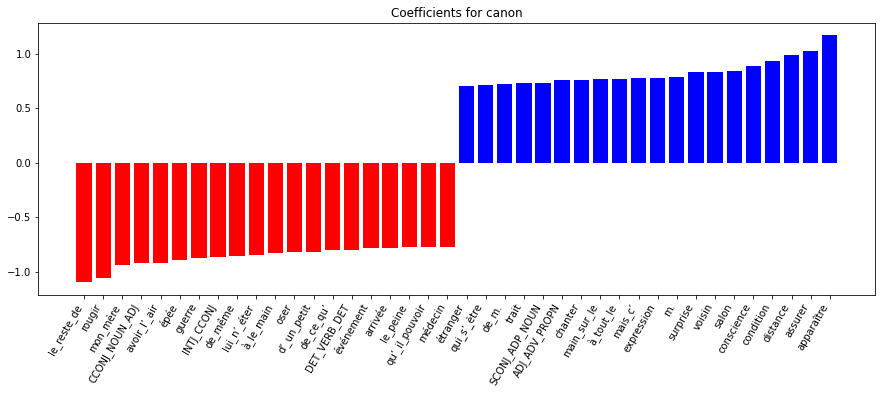

In [9]:
svm_1 = train_svm(df_train, df_test, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [5]:
df_main_temp = pd.read_csv(r'data\features_fabula.csv')

In [6]:
df_main_temp.set_index("index", inplace = True)

In [7]:
df_main_temp = df_main_temp.replace(np.nan, 0)

In [8]:
df_train_temp = df_main_temp.head(2664)
df_test_temp = df_main_temp.tail(296)

In [19]:
len(list(df_test_temp["canon"]))

296

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.91      0.92      0.92       174
        True       0.88      0.88      0.88       122

    accuracy                           0.90       296
   macro avg       0.90      0.90      0.90       296
weighted avg       0.90      0.90      0.90       296

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


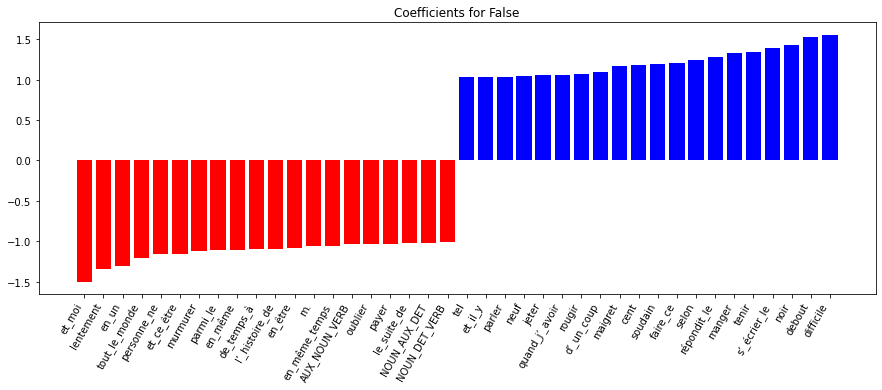

In [114]:
svm_test = train_svm(df_train_temp, df_test_temp, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [10]:
svm_test = train_svm(df_train_temp, df_test_temp, norms=True, kernel="rbf", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', SVC())]
              precision    recall  f1-score   support

       False       0.91      0.94      0.93       174
        True       0.91      0.87      0.89       122

    accuracy                           0.91       296
   macro avg       0.91      0.91      0.91       296
weighted avg       0.91      0.91      0.91       296



.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
.......... k-fold cross validation will be performed ........
.......... using 10 samples ........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   57.0s finished


              precision    recall  f1-score   support

       False       0.90      0.92      0.91      1631
        True       0.87      0.84      0.86      1033

    accuracy                           0.89      2664
   macro avg       0.89      0.88      0.89      2664
weighted avg       0.89      0.89      0.89      2664

.......... Training final SVM with all train set ........
.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


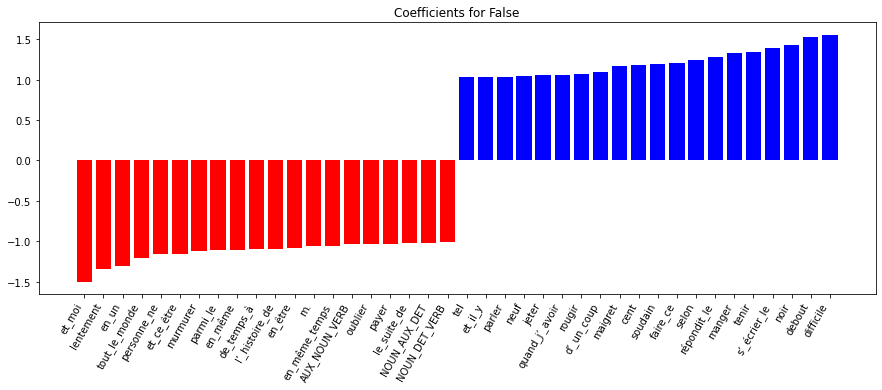

In [42]:
svm_cross_validated_fabula = train_svm(df_train_temp, df_test_temp, cross_validate='k-fold', norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [131]:
df_fabula_100 = df_main_temp.iloc[:, 0:100]

In [132]:
df_fabula_100['canon'] = df_main_temp['canon']

In [163]:
df_fabula_train = df_fabula_100.head(2664)
df_fabula_test = df_fabula_100.tail(296)

In [145]:
svm_fabula_100 = train_svm(df_fabula_train, df_fabula_test, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.86      0.85      0.86       174
        True       0.79      0.80      0.80       122

    accuracy                           0.83       296
   macro avg       0.83      0.83      0.83       296
weighted avg       0.83      0.83      0.83       296



In [137]:
df_fabula_1000 = df_main_temp.iloc[:, 0:1000]

In [138]:
df_fabula_1000['canon'] = df_main_temp['canon']

In [159]:
df_fabula_train = df_fabula_1000.head(2664)
df_fabula_test = df_fabula_1000.tail(296)

In [141]:
svm_fabula_1000 = train_svm(df_fabula_train, df_fabula_test, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.90      0.92      0.91       174
        True       0.88      0.86      0.87       122

    accuracy                           0.90       296
   macro avg       0.89      0.89      0.89       296
weighted avg       0.90      0.90      0.90       296



In [43]:
import random

In [44]:
random_list = [bool(random.getrandbits(1)) for i in range(2960)]

In [45]:
df_main_temp["canon"] = random_list

In [46]:
df_train_rand = df_main_temp.head(2664)
df_test_rand = df_main_temp.tail(296)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.55      0.55      0.55       146
        True       0.56      0.56      0.56       150

    accuracy                           0.55       296
   macro avg       0.55      0.55      0.55       296
weighted avg       0.55      0.55      0.55       296

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


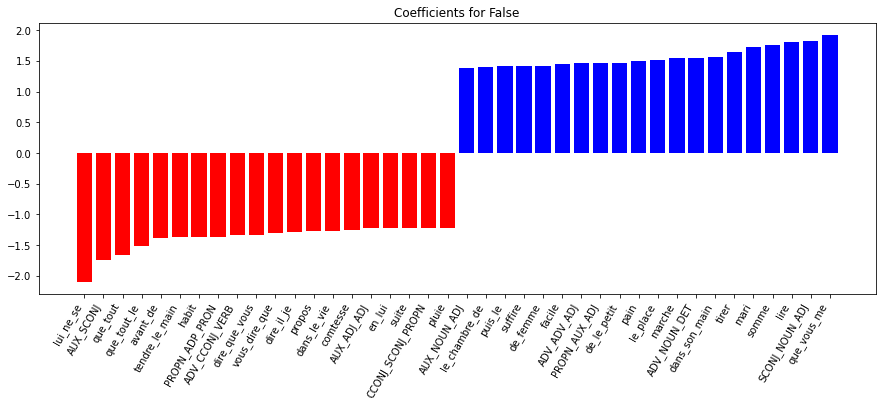

In [47]:
svm_3 = train_svm(df_train_rand, df_test_rand, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [19]:
df_fabula_ones = pd.read_csv(r'data\df_fabula_ones.csv')
df_fabula_ones.set_index("Unnamed: 0", inplace = True)
df_fabula_ones = df_fabula_ones.replace(np.nan, 0)

In [20]:
len(df_fabula_ones)

394

In [22]:
df_fabula_ones_train = df_main_temp.head(354)
df_fabula_ones_test = df_main_temp.tail(40)

In [25]:
svm_ones = train_svm(df_fabula_ones_train, df_fabula_ones_test, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.93      0.93      0.93        28
        True       0.83      0.83      0.83        12

    accuracy                           0.90        40
   macro avg       0.88      0.88      0.88        40
weighted avg       0.90      0.90      0.90        40



In [26]:
df_test = pd.read_csv(r'data/df_main_author.csv')
df_test.set_index("index", inplace = True)
df_test = df_test.replace(np.nan, 0)

In [27]:
len(df_test)

2200

In [28]:
df_train_test = df_main_balanced.head(1980)
df_test_test = df_main_balanced.tail(220)

In [30]:
svm_4 = train_svm(df_train_balanced, df_test_balanced, norms=True, kernel="rbf", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', SVC())]
              precision    recall  f1-score   support

       canon       0.83      0.83      0.83        30
   non_canon       0.77      0.77      0.77        22

    accuracy                           0.81        52
   macro avg       0.80      0.80      0.80        52
weighted avg       0.81      0.81      0.81        52



In [11]:
df_main_balanced = pd.read_csv(r'data\features_balanced.csv')
df_main_balanced.set_index("index", inplace = True)
df_main_balanced = df_main_balanced.replace(np.nan, 0)

In [14]:
df_train_balanced = df_main_balanced.head(470)
df_test_balanced = df_main_balanced.tail(52)

In [18]:
svm_4 = train_svm(df_train_balanced, df_test_balanced, norms=True, kernel="rbf", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', SVC())]
              precision    recall  f1-score   support

       canon       0.83      0.83      0.83        30
   non_canon       0.77      0.77      0.77        22

    accuracy                           0.81        52
   macro avg       0.80      0.80      0.80        52
weighted avg       0.81      0.81      0.81        52



.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       canon       0.81      0.83      0.82        30
   non_canon       0.76      0.73      0.74        22

    accuracy                           0.79        52
   macro avg       0.78      0.78      0.78        52
weighted avg       0.79      0.79      0.79        52

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


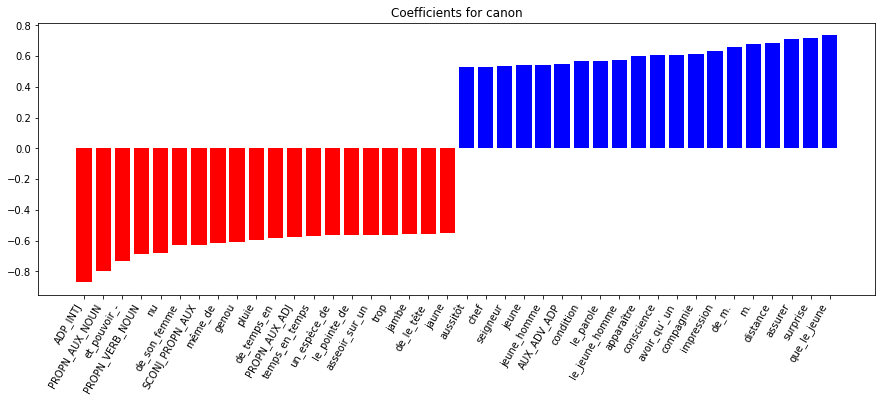

In [30]:
svm_4 = train_svm(df_train_balanced, df_test_balanced, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [31]:
svm_cross_validated = train_svm(df_train_balanced, df_test_balanced, cross_validate='k-fold', norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
.......... k-fold cross validation will be performed ........
.......... using 10 samples ........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.7s finished


              precision    recall  f1-score   support

       canon       0.69      0.76      0.72       231
   non_canon       0.74      0.67      0.70       239

    accuracy                           0.71       470
   macro avg       0.72      0.71      0.71       470
weighted avg       0.72      0.71      0.71       470



In [146]:
df_main_balanced_unigram = pd.read_csv(r'data\features_balanced_unigram.csv')
df_main_balanced_unigram.set_index("index", inplace = True)
df_main_balanced_unigram = df_main_balanced_unigram.replace(np.nan, 0)

In [147]:
df_main_balanced_unigram.set_index("index", inplace = True)

In [148]:
df_main_balanced_unigram = df_main_balanced_unigram.replace(np.nan, 0)

In [149]:
df_train_balanced_unigram = df_main_balanced_unigram.head(470)
df_test_balanced_unigram = df_main_balanced_unigram.tail(52)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       canon       0.79      0.73      0.76        30
   non_canon       0.67      0.73      0.70        22

    accuracy                           0.73        52
   macro avg       0.73      0.73      0.73        52
weighted avg       0.74      0.73      0.73        52

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


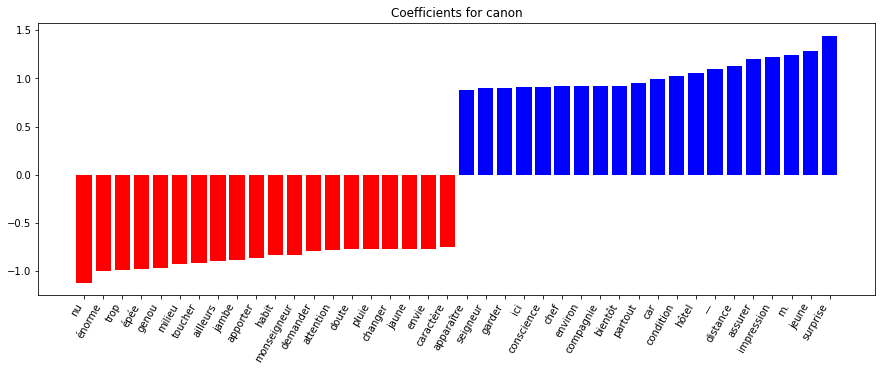

In [150]:
svm_5 = train_svm(df_train_balanced_unigram, df_test_balanced_unigram, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [37]:
df_100_most_common_unigrams = df_main_balanced_unigram.iloc[:, 0:100]

In [38]:
df_100_most_common_unigrams['canon'] = df_main_balanced_unigram['canon']

In [39]:
df_train_balanced_100_most_common_unigrams = df_100_most_common_unigrams.head(470)
df_test_balanced_100_most_common_unigrams = df_100_most_common_unigrams.tail(52)

In [40]:
list_100_mots = list(df_train_balanced_100_most_common_unigrams.columns)

In [151]:
svm_5bis = train_svm(df_train_balanced_100_most_common_unigrams, df_test_balanced_100_most_common_unigrams, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       canon       0.85      0.77      0.81        30
   non_canon       0.72      0.82      0.77        22

    accuracy                           0.79        52
   macro avg       0.79      0.79      0.79        52
weighted avg       0.80      0.79      0.79        52



In [58]:
df_main_balanced_tout_sauf_unigram = pd.read_csv(r'features_balanced_tout_sauf_unigram.csv')

In [46]:
df_main_balanced_tout_sauf_unigram.set_index("index", inplace = True)

In [47]:
df_main_balanced_tout_sauf_unigram = df_main_balanced_tout_sauf_unigram.replace(np.nan, 0)

In [48]:
df_train_balanced_tout_sauf_unigram = df_main_balanced_tout_sauf_unigram.head(470)
df_test_balanced_tout_sauf_unigram = df_main_balanced_tout_sauf_unigram.tail(52)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('normalizer', Normalizer(copy=True, norm='l2')), ('model', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]
              precision    recall  f1-score   support

       canon       0.79      0.77      0.78        30
   non_canon       0.70      0.73      0.71        22

    accuracy                           0.75        52
   macro avg       0.74      0.75      0.75        52
weighted avg       0.75      0.75      0.75        52

..........   Get Coef    ..........


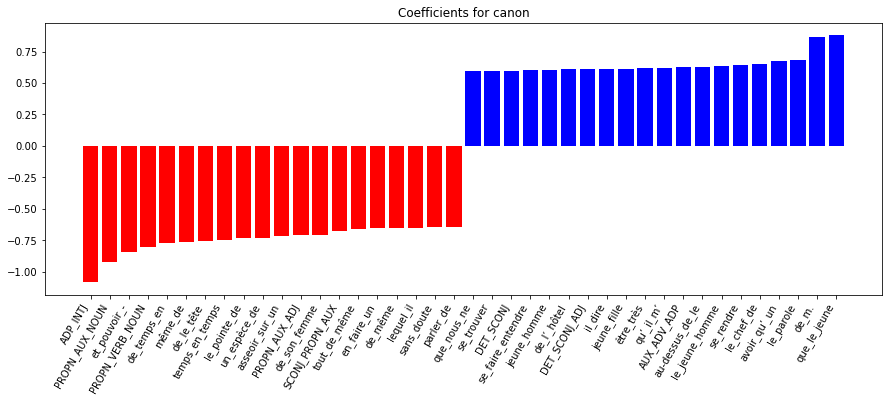

In [260]:
svm_6 = train_svm(df_train_balanced_tout_sauf_unigram, df_test_balanced_tout_sauf_unigram, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [8]:
df_main_ones = pd.read_csv(r'data\df_main_ones.csv')
df_main_ones.rename(columns = {'Unnamed: 0':'index'}, inplace = True)
df_main_ones.set_index("index", inplace = True)
df_main_ones = df_main_ones.replace(np.nan, 0)

In [13]:
df_train_ones = df_main_ones.head(107)
df_test_ones = df_main_ones.tail(27)

In [14]:
svm_6 = train_svm(df_train_ones, df_test_ones, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       canon       0.89      0.53      0.67        15
   non_canon       0.61      0.92      0.73        12

    accuracy                           0.70        27
   macro avg       0.75      0.72      0.70        27
weighted avg       0.77      0.70      0.70        27



In [20]:
df_fabula_ones = pd.read_csv(r'data\df_fabula_ones.csv')
df_fabula_ones.rename(columns = {'Unnamed: 0':'index'}, inplace = True)
df_fabula_ones.set_index('index', inplace = True)
df_fabula_ones = df_fabula_ones.replace(np.nan, 0)

In [25]:
df_fabula_train_ones = df_fabula_ones.head(315)
df_fabula_test_ones = df_fabula_ones.tail(79)

In [26]:
svm_6 = train_svm(df_fabula_train_ones, df_fabula_test_ones, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.78      0.80      0.79        50
        True       0.64      0.62      0.63        29

    accuracy                           0.73        79
   macro avg       0.71      0.71      0.71        79
weighted avg       0.73      0.73      0.73        79



In [57]:
from sklearn import linear_model

In [194]:
classifier = linear_model.LogisticRegression(C=10000, max_iter=1000)

In [195]:
classifier.fit(df_train_balanced_unigram.drop(['canon'], axis=1), df_train_balanced_unigram['canon'])

LogisticRegression(C=10000, max_iter=1000)

In [196]:
classifier.score(df_test_balanced_unigram.drop(['canon'], axis=1), df_test_balanced_unigram['canon'])

0.8076923076923077

In [197]:
 classifier.decision_function(df_test_balanced_unigram.drop(['canon'], axis=1))

array([ 1.20062259, -0.62812441, -0.15877607,  0.2910872 , -1.04395398,
       -0.68045295,  0.98135748,  0.14525938,  1.306635  ,  0.85410073,
        1.1069602 ,  1.49869089,  0.35521813, -0.75573399, -0.62188869,
       -1.07613175, -0.43883534,  0.47558373, -0.9914549 ,  0.14298441,
       -0.47032354,  0.90070928, -0.95236253,  1.37319049, -0.3923139 ,
        0.75874511, -0.5498779 ,  0.12048466,  1.53138868, -0.65953291,
        1.36210714, -1.40899629, -0.50919068,  2.27330626,  2.26368031,
       -0.36759136, -1.37925698, -1.57289478,  2.27186979, -0.65656463,
        0.80528373,  0.14091805,  0.58939893, -1.85084211, -1.29731639,
       -1.29776784, -1.49169505, -0.80904085,  0.25619906,  0.97488907,
        1.52152393, -0.54745147])

In [199]:
Y_test = classifier.predict(df_test_balanced_unigram.drop(['canon'], axis=1))

In [219]:
classifier.classes_

array(['canon', 'non_canon'], dtype=object)

In [224]:
df = pd.DataFrame()
df['metadata'] = df_test_balanced_unigram['canon']

In [226]:
df['proba'] = list(classifier.predict_proba(df_test_balanced_unigram.drop(['canon'], axis=1)))

In [227]:
df['prediction']= list(classifier.predict(df_test_balanced_unigram.drop(['canon'], axis=1)))

In [228]:
df

,metadata,proba,prediction
index,,,
1906_Bazin-Rene_Stephanette,non_canon,"[0.23136447960645434, 0.7686355203935457]",non_canon
1925_Proust-Marcel_Albertine-disparue,canon,"[0.6520640558403874, 0.3479359441596126]",canon
1934_Vercel-Roger_Capitaine-Conan,canon,"[0.539610838400394, 0.46038916159960597]",canon
1842_Balzac-Honore-de_Le-Contrat-de-mariage,canon,"[0.427737723738033, 0.572262276261967]",non_canon
1889_Guy-de-Maupassant_La-main-gauche,canon,"[0.7396122092060067, 0.2603877907939934]",canon
1991_Combescot-Pierre_Les-filles-du-Calvaire,canon,"[0.6638397834112879, 0.33616021658871204]",canon
1845_Sue-Eugene_La-coucaratcha_Tome-III,non_canon,"[0.27262251209589683, 0.7273774879041032]",non_canon
1890_Delpit-Edouard_Yvonne,non_canon,"[0.4637488761156474, 0.5362511238843526]",non_canon
1845_Dumas-Alexandre_Le-batard-de-Mauleon_I,non_canon,"[0.21305047438762525, 0.7869495256123747]",non_canon


In [155]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [160]:
pipe = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
pipe.fit(df_fabula_train.drop(['canon'], axis=1), df_fabula_train['canon'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

In [165]:
pipe = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
pipe.fit(df_fabula_train.drop(['canon'], axis=1), df_fabula_train['canon'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

In [166]:
pipe.score(df_fabula_test.drop(['canon'], axis=1), df_fabula_test['canon'])

0.918918918918919

# Unigram Balanced Data

In [51]:
pipe = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))

In [52]:
pipe.fit(df_train_balanced_unigram.drop(['canon'], axis=1), df_train_balanced_unigram['canon'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

In [53]:
pipe.score(df_test_balanced_unigram.drop(['canon'], axis=1), df_test_balanced_unigram['canon'])

0.7884615384615384

In [54]:
pipe.classes_

array(['canon', 'non_canon'], dtype=object)

In [77]:
df_test_res = pd.DataFrame()
df_test_res['metadata'] = df_test_balanced_unigram['canon']
df_test_res['proba canon'] = pipe.predict_proba(df_test_balanced_unigram.drop(['canon'], axis=1))[:,0]
df_test_res['proba non-canon'] = pipe.predict_proba(df_test_balanced_unigram.drop(['canon'], axis=1))[:,1]
df_test_res['prediction']= pipe.predict(df_test_balanced_unigram.drop(['canon'], axis=1))

In [78]:
df_test_res['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_test.iterrows()]

In [79]:
df_test_res['accord'].value_counts(normalize=True)*100

True     78.846154
False    21.153846
Name: accord, dtype: float64

In [80]:
df_test_res.to_csv('df_test_results.csv')

In [81]:
df_test_res

,metadata,proba canon,proba non-canon,prediction,accord
index,,,,,
1906_Bazin-Rene_Stephanette,non_canon,0.135731,0.864269,non_canon,True
1925_Proust-Marcel_Albertine-disparue,canon,0.359348,0.640652,non_canon,False
1934_Vercel-Roger_Capitaine-Conan,canon,0.740349,0.259651,canon,True
1842_Balzac-Honore-de_Le-Contrat-de-mariage,canon,0.490124,0.509876,canon,True
1889_Guy-de-Maupassant_La-main-gauche,canon,0.897291,0.102709,canon,True
1991_Combescot-Pierre_Les-filles-du-Calvaire,canon,0.709550,0.290450,canon,True
1845_Sue-Eugene_La-coucaratcha_Tome-III,non_canon,0.288546,0.711454,non_canon,True
1890_Delpit-Edouard_Yvonne,non_canon,0.204836,0.795164,non_canon,True
1845_Dumas-Alexandre_Le-batard-de-Mauleon_I,non_canon,0.237078,0.762922,non_canon,True


In [73]:
df_train_res = pd.DataFrame()
df_train_res['metadata'] = df_train_balanced_unigram['canon']
df_train_res['proba canon'] = pipe.predict_proba(df_train_balanced_unigram.drop(['canon'], axis=1))[:,0]
df_train_res['proba non-canon'] = pipe.predict_proba(df_train_balanced_unigram.drop(['canon'], axis=1))[:,1]
df_train_res['prediction']= pipe.predict(df_train_balanced_unigram.drop(['canon'], axis=1))

In [74]:
df_train_res['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_train_res.iterrows()]

In [75]:
df_train_res['accord'].value_counts(normalize=True)*100

True     95.319149
False     4.680851
Name: accord, dtype: float64

In [76]:
df_train_res

,metadata,proba canon,proba non-canon,prediction,accord
index,,,,,
1950_Duras-Marguerite_Un-barrage-contre-le-Pacifique,canon,0.900323,0.099677,canon,True
1905_Farrere-Claude_Les-civilises,canon,0.900253,0.099747,canon,True
1978_Delly_Le-testament-de-Mr.-d'Erquoy,non_canon,0.049690,0.950310,non_canon,True
1888_Zola-Emile_Le-reve,canon,0.900292,0.099708,canon,True
1921_Pagnol-Marcel_La-Petite-Fille-aux-yeux-sombres-suivi-de-Les-secrets-de-Dieu,non_canon,0.090509,0.909491,non_canon,True
...,...,...,...,...,...
1872_Verne-Jules_Le-tour-du-monde-en-quatre-vingts-jours,non_canon,0.078293,0.921707,non_canon,True
2008_Vargas-Fred_Un-lieu-incertain,non_canon,0.132647,0.867353,non_canon,True
2003_Ferney-Alice_Dans-la-guerre,non_canon,0.185445,0.814555,non_canon,True


In [64]:
df_train.to_csv('df_train_results.csv')

# All Balanced Data

In [70]:
pipe2 = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [71]:
pipe2.fit(df_train_balanced.drop(['canon'], axis=1), df_train_balanced['canon'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [72]:
pipe2.score(df_test_balanced.drop(['canon'], axis=1), df_test_balanced['canon'])

0.8076923076923077

In [300]:
pipe2.decision_function(df_train_balanced.drop(['canon'], axis=1))

array([-1.00001966e+00, -1.00003186e+00,  1.00021946e+00, -1.00354049e+00,
        1.00020143e+00,  1.00011283e+00,  1.34669008e-03,  9.99698615e-01,
        9.99645402e-01, -1.00022511e+00,  9.65933535e-01, -9.99634980e-01,
        1.00046093e+00, -9.68336627e-01,  5.51426721e-02, -1.00019807e+00,
       -4.33092604e-01,  1.06490949e+00, -1.00006966e+00, -9.99929753e-01,
       -3.53724770e-01,  9.99952718e-01,  3.94470986e-01,  9.99975821e-01,
        1.00012426e+00, -9.99953281e-01, -7.38345492e-01, -7.10396013e-01,
        6.95027755e-01,  7.74082841e-01, -1.00008776e+00,  1.86496579e-01,
        1.00025806e+00,  2.84353352e-02,  1.09502631e+00,  1.00010136e+00,
        6.46917037e-01, -7.01238992e-01,  1.00020264e+00, -9.99959877e-01,
       -9.99958738e-01,  1.00012125e+00, -9.16463177e-01,  9.99696667e-01,
        7.66670839e-01, -9.99737112e-01,  9.15235800e-01, -4.95309279e-01,
       -1.12082466e-01, -8.66758696e-01, -2.86093385e-01,  1.00013634e+00,
       -9.87058984e-01, -

# Fabula Metadata

In [142]:
pipe3 = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [143]:
pipe3.fit(df_train_temp.drop(['canon'], axis=1), df_train_temp['canon'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [144]:
pipe3.score(df_test_temp.drop(['canon'], axis=1), df_test_temp['canon'])

0.9155405405405406

In [96]:
from sklearn import set_config
set_config(display='diagram')